## 18.3 使用PyTorch实现Q-Learning
	以下为实现Q-Learning的主要代码。
### 18.3.1 定义Q-Learing主函数
	本节详细代码号为pytorch-18-01。

In [1]:
import time
import numpy as np
import tkinter as tk
from PIL import ImageTk, Image

np.random.seed(1)
PhotoImage = ImageTk.PhotoImage
UNIT = 100
HEIGHT = 5
WIDTH = 5


class Env(tk.Tk):
    def __init__(self):
        super(Env, self).__init__()
        self.action_space = ['u', 'd', 'l', 'r']
        self.n_actions = len(self.action_space)
        self.title('Q Learning')
        self.geometry('{0}x{1}'.format(HEIGHT * UNIT, HEIGHT * UNIT))
        self.shapes = self.load_images()
        self.canvas = self._build_canvas()
        self.texts = []

    def _build_canvas(self):
        canvas = tk.Canvas(self, bg='white',
                           height=HEIGHT * UNIT,
                           width=WIDTH * UNIT)
        # create grids
        for c in range(0, WIDTH * UNIT, UNIT):  # 0~400 by 100
            x0, y0, x1, y1 = c, 0, c, HEIGHT * UNIT
            canvas.create_line(x0, y0, x1, y1)
        for r in range(0, HEIGHT * UNIT, UNIT):  # 0~400 by 100
            x0, y0, x1, y1 = 0, r, HEIGHT * UNIT, r
            canvas.create_line(x0, y0, x1, y1)

        # 把图标加载到环境中
        self.rectangle = canvas.create_image(50, 50, image=self.shapes[0])
        self.tree1 = canvas.create_image(250, 150, image=self.shapes[1])
        self.tree2 = canvas.create_image(150, 250, image=self.shapes[1])
        self.star = canvas.create_image(250, 250, image=self.shapes[2])

        # 对环境进行包装
        canvas.pack()

        return canvas

    def load_images(self):
        rectangle = PhotoImage(
            Image.open("img/bob.png").resize((65, 65)))
        tree = PhotoImage(
            Image.open("img/tree.png").resize((65, 65)))
        star = PhotoImage(
            Image.open("img/star.jpg").resize((65, 65)))

        return rectangle, tree, star

    def text_value(self, row, col, contents, action, font='Helvetica', size=10,
                   style='normal', anchor="nw"):
        if action == 0:
            origin_x, origin_y = 7, 42
        elif action == 1:
            origin_x, origin_y = 85, 42
        elif action == 2:
            origin_x, origin_y = 42, 5
        else:
            origin_x, origin_y = 42, 77

        x, y = origin_y + (UNIT * col), origin_x + (UNIT * row)
        font = (font, str(size), style)
        text = self.canvas.create_text(x, y, fill="black", text=contents,
                                       font=font, anchor=anchor)
        return self.texts.append(text)

    def print_value_all(self, q_table):
        for i in self.texts:
            self.canvas.delete(i)
        self.texts.clear()
        for i in range(HEIGHT):
            for j in range(WIDTH):
                for action in range(0, 4):
                    state = [i, j]
                    if str(state) in q_table.keys():
                        temp = q_table[str(state)][action]
                        self.text_value(j, i, round(temp, 2), action)

    def coords_to_state(self, coords):
        x = int((coords[0] - 50) / 100)
        y = int((coords[1] - 50) / 100)
        return [x, y]

    def state_to_coords(self, state):
        x = int(state[0] * 100 + 50)
        y = int(state[1] * 100 + 50)
        return [x, y]

    def reset(self):
        self.update()
        time.sleep(0.5)
        x, y = self.canvas.coords(self.rectangle)
        self.canvas.move(self.rectangle, UNIT / 2 - x, UNIT / 2 - y)
        self.render()
        # return observation
        return self.coords_to_state(self.canvas.coords(self.rectangle))

    def step(self, action):
        state = self.canvas.coords(self.rectangle)
        base_action = np.array([0, 0])
        self.render()

        if action == 0:  # up
            if state[1] > UNIT:
                base_action[1] -= UNIT
        elif action == 1:  # down
            if state[1] < (HEIGHT - 1) * UNIT:
                base_action[1] += UNIT
        elif action == 2:  # left
            if state[0] > UNIT:
                base_action[0] -= UNIT
        elif action == 3:  # right
            if state[0] < (WIDTH - 1) * UNIT:
                base_action[0] += UNIT

        # 移动
        self.canvas.move(self.rectangle, base_action[0], base_action[1])
        self.canvas.tag_raise(self.rectangle)
        next_state = self.canvas.coords(self.rectangle)
        # 判断得分条件
        if next_state == self.canvas.coords(self.star):
            reward = 100
            done = True
        elif next_state in [self.canvas.coords(self.tree1),
                            self.canvas.coords(self.tree2)]:
            reward = -100
            done = True
        else:
            reward = 0
            done = False

        next_state = self.coords_to_state(next_state)
        return next_state, reward, done

    # 渲染环境
    def render(self):
        time.sleep(0.03)
        self.update()

### 18.3.2执行Q-Learing
	实例化环境，开始运行。

In [2]:
import numpy as np
import random
from collections import defaultdict


class QLearningAgent:
    def __init__(self, actions):
        # 四种动作分别用序列表示：[0, 1, 2, 3]
        self.actions = actions
        self.learning_rate = 0.01
        self.discount_factor = 0.9
        #epsilon贪婪策略取值
        self.epsilon = 0.1
        self.q_table = defaultdict(lambda: [0.0, 0.0, 0.0, 0.0])

    # 采样 <s, a, r, s'>
    def learn(self, state, action, reward, next_state):
        current_q = self.q_table[state][action]
        # 更新Q表
        new_q = reward + self.discount_factor * max(self.q_table[next_state])
        self.q_table[state][action] += self.learning_rate * (new_q - current_q)

    # 从Q-table中选取动作
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            # 贪婪策略随机探索动作
            action = np.random.choice(self.actions)
        else:
            # 从q表中选择
            state_action = self.q_table[state]
            action = self.arg_max(state_action)
        return action

    @staticmethod
    def arg_max(state_action):
        max_index_list = []
        max_value = state_action[0]
        for index, value in enumerate(state_action):
            if value > max_value:
                max_index_list.clear()
                max_value = value
                max_index_list.append(index)
            elif value == max_value:
                max_index_list.append(index)
        return random.choice(max_index_list)

运行程序（如果是在远程服务器上运行，需要借助xshell客户端，即需要先用xshell连接服务器。  
如果在windows环境，不需要xshell）

In [3]:
env = Env()
agent = QLearningAgent(actions=list(range(env.n_actions)))
#共进行200次游戏
for episode in range(200):
    state = env.reset()
    while True:
        env.render()
        # agent产生动作
        action = agent.get_action(str(state))
        next_state, reward, done = env.step(action)
        # 更新Q表
        agent.learn(str(state), action, reward, str(next_state))
        state = next_state
        env.print_value_all(agent.q_table)
        # 当到达终点就终止游戏开始新一轮训练
        if done:
            break

TclError: invalid command name ".!canvas"

运行结果示意图
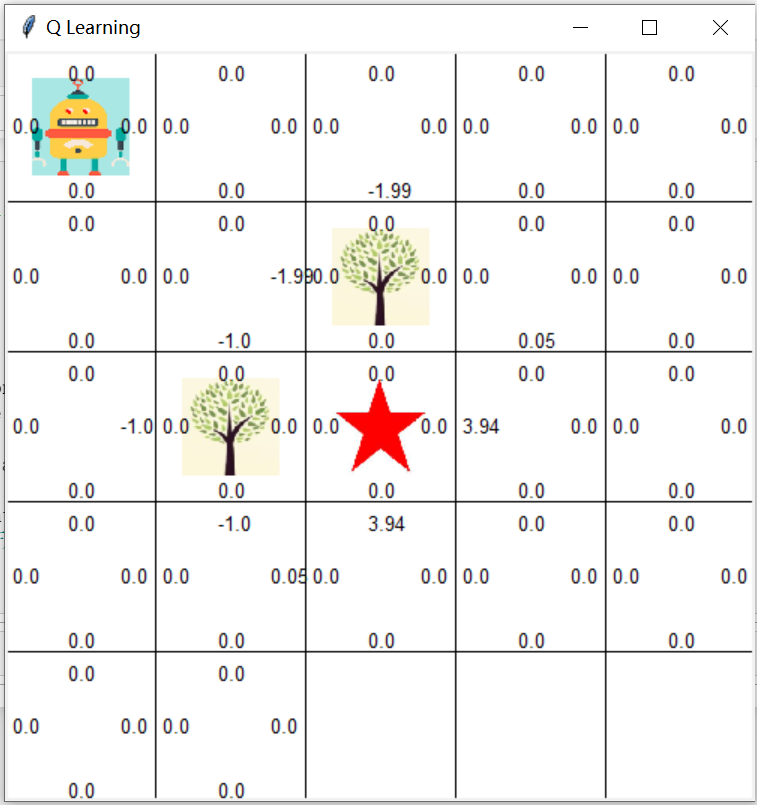